In [4]:
%pip install keras
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.17.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.1 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.2/236.2 MB 5.5 MB/s eta 0:00:00:00:0100:01
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached flatbuffers-24.3.25-py2.py3

In [5]:
import os

# os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [80]:
imgs = np.load("/Users/anavbo/Desktop/Personal/ASDRP/augment_images.npy")

In [81]:
df = pd.read_csv("/Users/anavbo/Desktop/Personal/ASDRP/HAM10000_metadata_augmented.csv")
df.head()

,image_id,dx,dx_type,lesion_id,sex,age,localization
0,ISIC_0034320,nv,follow_up,HAM_0000550,male,45.0,trunk
1,ISIC_0034320,nv,follow_up,HAM_0003577,male,50.0,lower extremity
2,ISIC_0034320,nv,follow_up,HAM_0001477,female,55.0,trunk
3,ISIC_0034320,nv,follow_up,HAM_0000484,male,40.0,trunk
4,ISIC_0034320,mel,histo,HAM_0003350,male,60.0,chest


In [8]:
print(df.shape)
print(imgs.shape)

(40949, 7)
(40949, 100, 100, 3)


In [147]:
target = df[['dx']]
target = pd.get_dummies(target, columns=['dx'], prefix='dx', dtype=int)
target.head()

,dx_akiec,dx_bcc,dx_bkl,dx_df,dx_mel,dx_nv,dx_vasc
0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0


In [164]:
df.replace({'dx': {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}}, inplace=True)

In [165]:
classes=  7
shape = (100, 100, 3)
split = 35000

(x_train, y_train), (x_test, y_test) = (imgs[:split], df["dx"][:split]), (imgs[split:], df["dx"][split:])
# y_train = pd.get_dummies(y_train, dtype=np.float32).to_numpy()
# y_test = pd.get_dummies(y_test, dtype=np.float32).to_numpy()
# y_train = np.expand_dims(y_train, axis=-1)
# y_test = np.expand_dims(y_test, axis=-1)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(y_train.head())

(35000, 100, 100, 3) (35000,) (5949, 100, 100, 3) (5949,)
0    5
1    5
2    5
3    5
4    4
Name: dx, dtype: int64


In [166]:
class CFG:
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 256
    num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
    image_size = 100  # We'll resize input images to this size
    patch_size = 10  # Size of the patches to be extract from the input images
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]  # Size of the transformer layers
    transformer_layers = 8
    mlp_head_units = [
        2048,
        1024
    ]  # Size of the dense layers of the final classifier
    num_classes = 7
    input_shape = (image_size, image_size, 3)

In [152]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [153]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(
            images=images,
            size = self.patch_size
        )
        patches = ops.reshape(
            patches,
            (batch_size, num_patches_h * num_patches_w, self.patch_size ** 2 * channels)
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 100 X 100
Patch size: 10 X 10
Patches per image: 100
Elements per patch: 300


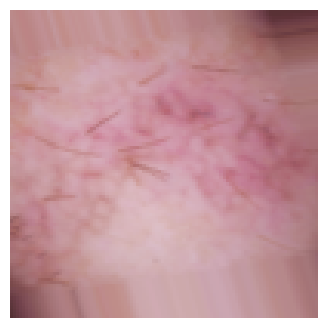

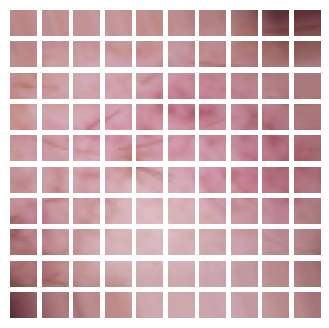

In [154]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(CFG.image_size, CFG.image_size)
)
patches = Patches(CFG.patch_size)(resized_image)
print(f"Image size: {CFG.image_size} X {CFG.image_size}")
print(f"Patch size: {CFG.patch_size} X {CFG.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (CFG.patch_size, CFG.patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [155]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [156]:
def create_vit_classifier():
    inputs = keras.Input(shape=CFG.input_shape)
    patches = Patches(CFG.patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(CFG.num_patches, CFG.projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(CFG.transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=CFG.num_heads, key_dim=CFG.projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=CFG.transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=CFG.mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    # logits = layers.Dense(CFG.num_classes)(features)
    logits = layers.Dense(7, activation="softmax")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [157]:
# def batchify(x, y):
#     q = x.shape[0] // 1
#     block_end = q * 1
#     x = np.array(np.split(x[:block_end], q))
#     y = np.array(np.split(y[:block_end], q))
#     return x, y

# x_train, y_train = batchify(x_train, y_train)
# x_test, y_test = batchify(x_test, y_test)
# # x_train = np.expand_dims(x_train, axis=2)
print(x_train.shape)
print(y_train.shape)

(35000, 100, 100, 3)
(35000, 7)


In [158]:
vit_classifier = create_vit_classifier()
vit_classifier.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_20          │ (None, 100, 300)  │          0 │ input_layer_15[0… │
│ (Patches)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_15    │ (None, 100, 64)   │     25,664 │ patches_20[0][0]  │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ patch_encoder_15… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_210 (Add)       │ (None, 100, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_210[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_265 (Dense)   │ (None, 100, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_354         │ (None, 100, 128)  │          0 │ dense_265[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_266 (Dense)   │ (None, 100, 64)   │      8,256 │ dropout_354[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_355         │ (None, 100, 64)   │          0 │ dense_266[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_211 (Add)       │ (None, 100, 64)   │          0 │ dropout_355[0][0… │
│                     │                   │            │ add_210[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_211[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_212 (Add)       │ (None, 100, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_211[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_212[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_267 (Dense)   │ (None, 100, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_357         │ (None, 100, 128)  │          0 │ dense_267[0][0] 

 Total params: 15,905,991 (60.68 MB)

 Trainable params: 15,905,991 (60.68 MB)

 Non-trainable params: 0 (0.00 B)

In [159]:
def run_experiment(model: keras.Model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=CFG.learning_rate, weight_decay=CFG.weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/Users/anavbo/Desktop/Personal/ASDRP/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    print(y_train.shape)
    history = model.fit(
        x=x_train,
        y=y_train,
        # batch_size=CFG.batch_size,
        batch_size=1,
        epochs=CFG.num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
        verbose=2,
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [167]:
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

(35000,)
Epoch 1/10


/Users/anavbo/anaconda3/envs/env_var/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


KeyboardInterrupt: 